In [481]:
import numpy as np
import pandas as pd
import re
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

import nltk # text cleaning and datasets 
import re # patterns searching in strings

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

#### Import data from nltk.corpus and establish train/test inputs and targets

In [3]:
from nltk.corpus import reuters

In [4]:
all_docs = reuters.fileids()
train_doc_names = [doc for doc in all_docs if doc.startswith("train")]
test_doc_names = [doc for doc in all_docs if doc.startswith("test")]

In [156]:
X_train, y_train = zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in train_doc_names])
X_test, y_test= zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in test_doc_names])
X_all = X_train + X_test
y_all = y_train + y_test

### Review the data:

In [18]:
# Number of articles:
print(f"Number of train articles: {len(X_train)}")
print(f"Number of test articles: {len(X_test)}")

Number of train articles: 7769
Number of test articles: 3019


#### Review labels

In [22]:
y_train_flat = pd.Series(itertools.chain(*y_train))
y_test_flat = pd.Series(itertools.chain(*y_train))

In [25]:
print(f"Avg number of labels per article in train set: {(len(y_train_flat) / len(y_train) ):.2f}")
# print(f"Avg number of labels per article in test set: {(len(y_test_flat) / len(y_test) ):.2f}")

Avg number of labels per article in train set: 1.23


In [9]:
# Count number of labels for each article
labels_len = [len(labels) for labels in y_train]
# Group 
labels_freq = {n: labels_len.count(n) for n in labels_len}
labels_freq = dict(sorted(labels_freq.items()))
print(f"Number of labels assigned to article: Total number of such occurances")
labels_freq

Number of labels assigned to article: Total number of such occurances


{1: 6577,
 2: 865,
 3: 192,
 4: 59,
 5: 37,
 6: 22,
 7: 5,
 8: 5,
 9: 3,
 10: 2,
 11: 1,
 15: 1}

Conclusion: For most of the cases in the train set - there is only 1 label associated with article.

#### Review classes

In [21]:
print(f"Total number of classes: {len(reuters.categories())}")

Total number of classes: 90


In [27]:
cat_distr = y_train_flat.value_counts()
cat_distr.head(5)

earn        2877
acq         1650
money-fx     538
grain        433
crude        389
dtype: int64

In [61]:
cat_distr.tail(5)

sun-meal         1
castor-oil       1
groundnut-oil    1
nkr              1
lin-oil          1
dtype: int64

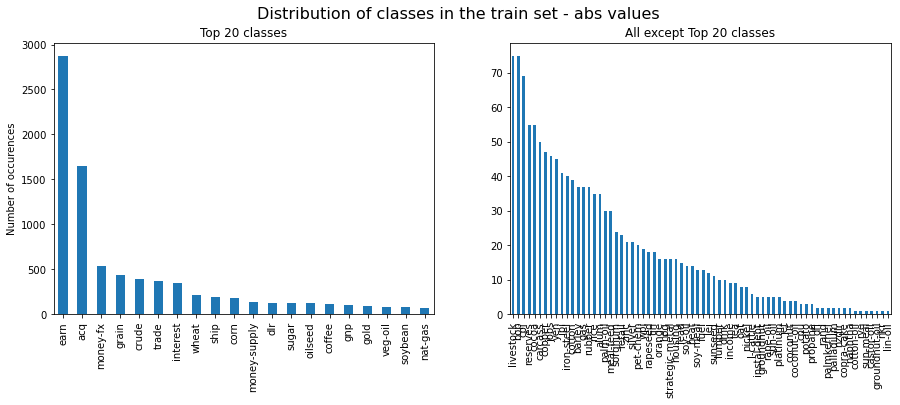

In [65]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - abs values', fontsize = 16)

plt.subplot(1,2,1)
cat_distr[:n].plot.bar()
plt.ylabel(f'Number of occurences');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
cat_distr[n:].plot.bar()
plt.title(f'All except Top {n} classes');

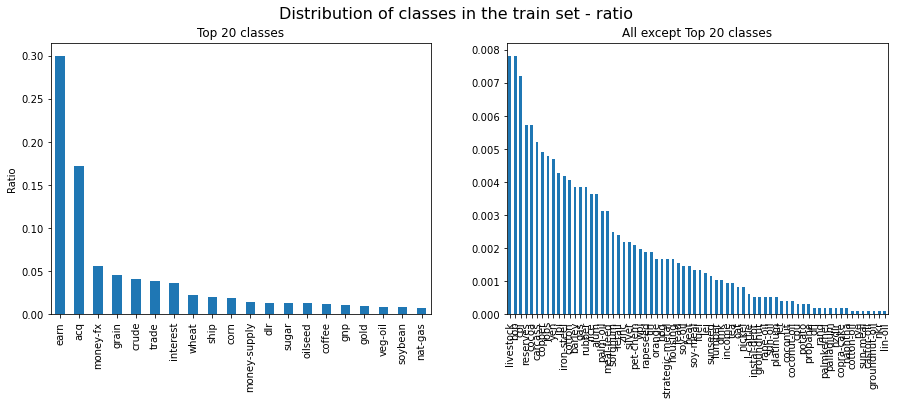

In [66]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - ratio', fontsize = 16)

plt.subplot(1,2,1)
(cat_distr[:n]/cat_distr.sum()).plot.bar()
plt.ylabel(f'Ratio');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
(cat_distr[n:]/cat_distr.sum()).plot.bar()
plt.title(f'All except Top {n} classes');

Conclusion: Top 2 classes are far more frequent than other classes (more than 45% of all targets)

#### Review the raw articles

In [92]:
type(X_train[0])

str

In [94]:
art_len = [len(art) for art in X_train]

In [100]:
print(f"Character count for the shortest article: {min(art_len)}")
print(f"Character count for the longest article: {max(art_len)}")

Character count for the shortest article: 27
Character count for the longest article: 8898


In [143]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
# ax1.hist(art_len, bins=50, rwidth = 0.9);

(0.0, 200.0)

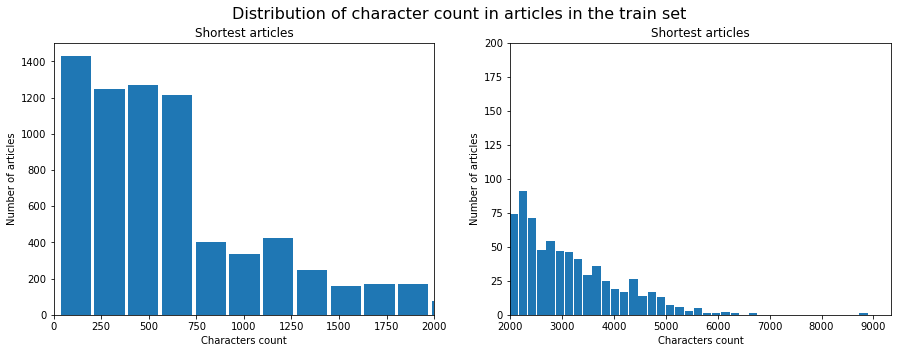

In [147]:
n=2000 # split between left and right graph (number of characters)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of character count in articles in the train set', fontsize = 16)

plt.subplot(1,2,1)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Shortest articles');
plt.xlim(0,n)

plt.subplot(1,2,2)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Shortest articles');
plt.xlim(n,)
plt.ylim(0,200)

# plt.tight_layout()
# ax.set(ylabel = 'aaa')

In [159]:
X_train[0][:300]

'BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.\n      The dry p'

## Side analysis START

In [284]:
min(X_train, key=len)

'26-FEB-1987\n  26-FEB-1987\n\n'

In [283]:
min(X_train)

' 1-APR-1987 17:39:30.41\n   1-APR-1987 17:39:30.41\n\n'

In [278]:
X_train.index(min(X_train, key=len))

66

In [279]:
X_train.index(min(X_train))

1533

In [267]:
y_train[1533]

['grain', 'ship']

In [265]:
y_train[66]

['money-supply']

## Side analysis END

### Clean text

In [192]:
# Remove html:
# X_train_clean =  [re.sub("<.+?>", " ", a) for a in X_train]
# X_train_clean[0][:300]

In [230]:
# Convert to lower case
X_train_clean =  [a.lower() for a in X_train]
X_train_clean[0][:300]

'bahia cocoa review\n  showers continued throughout the week in\n  the bahia cocoa zone, alleviating the drought since early\n  january and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  comissaria smith said in its weekly review.\n      the dry p'

In [231]:
# Remove string control characters (e.g. \n \t...)
X_train_clean = [re.sub("\s+", " ", a) for a in X_train_clean]
X_train_clean[0][:300]

'bahia cocoa review showers continued throughout the week in the bahia cocoa zone, alleviating the drought since early january and improving prospects for the coming temporao, although normal humidity levels have not been restored, comissaria smith said in its weekly review. the dry period means the '

In [232]:
# Tokenization
X_train_clean = [nltk.word_tokenize(a) for a in X_train_clean]
print(X_train_clean[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'the', 'week', 'in', 'the', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'the', 'drought', 'since', 'early', 'january']


In [233]:
# Remove stopwords
stopwords =nltk.corpus.stopwords.words("english")
X_train_clean = [[w for w in a if w not in stopwords] for a in X_train_clean]
print(X_train_clean[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao']


In [234]:
# Remove punctuations
import string
punctuations = [char for char in string.punctuation]

X_train_clean = [[w for w in a if w not in punctuations] for a in X_train_clean]
print(X_train_clean[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao', 'although']


In [235]:
# Token normalization - stemming with PorterStemmer 
# It is not important to keep "real" language words, so stemming (as being faster) is a better choice than lemmatization
stemmer = nltk.PorterStemmer()

X_train_clean = [[stemmer.stem(w) for w in a] for a in X_train_clean]
print(X_train_clean[0][:60])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although']


In [237]:
# Remove numbers
# ??? Consider converting all numbers to "number" string instead of removing them ???
X_train_clean = [[re.sub('[^A-Za-z]+', '', w) for w in a] for a in X_train_clean]
print(X_train_clean[0][:60])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', '', '', 'bag', '', 'kilo', 'make', 'cumul', 'total', 'season', '', 'mln', '', 'stage', 'last', 'year', 'seem', 'cocoa', 'deliv', 'earlier', 'consign', 'includ']


In [238]:
# Remove words shorter than k characters
# ??? Consider using ???

# k = 2
# X_train_clean = [[w for w in a if len(w) > k] for a in X_train_clean]
# X_train_clean[0]

In [239]:
# Remove empty strings after number removal
X_train_clean = [list(filter(None, a)) for a in X_train_clean]
print(X_train_clean[0][:60])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', 'bag', 'kilo', 'make', 'cumul', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seem', 'cocoa', 'deliv', 'earlier', 'consign', 'includ', 'arriv', 'figur', 'comissaria', 'smith', 'said']


In [242]:
# Merge back the text
X_train_clean = [" ".join(a) for a in X_train_clean]
X_train_clean[0][:500]

'bahia cocoa review shower continu throughout week bahia cocoa zone allevi drought sinc earli januari improv prospect come temporao although normal humid level restor comissaria smith said weekli review dri period mean temporao late year arriv week end februari bag kilo make cumul total season mln stage last year seem cocoa deliv earlier consign includ arriv figur comissaria smith said still doubt much old crop cocoa still avail harvest practic come end total bahia crop estim around mln bag sale '

### Text vectorization
Plan to review TFIDF, FastText, doc2vec

What about Skip-Thought Vectors??

#### TFIDF

In [293]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer?

In [392]:
tfidf_vectorizer = TfidfVectorizer()
# No upper, lower limits, 1-gram

tfidf_fit = tfidf_vectorizer.fit(X_train_clean)
tfidf_trans = tfidf.transform(X_train_clean)

In [393]:
print(f"Number of remaining tokens: {tfidf_trans.shape[1]}")

Number of remaining tokens: 20197


In [394]:
# Take a dense tfidf with feature names
df_tfidf = pd.DataFrame(tfidf_trans.todense().T, index=tfidf_fit.get_feature_names())

In [395]:
# Show examplary values for article 0 for non-zero tokens only
df_tfidf.loc[(tfidf_dense != 0).any(axis=1), [0]]

,0
allevi,0.052519
almost,0.035703
also,0.018691
although,0.031366
aprilmay,0.051161
...,...
went,0.040147
would,0.017645
year,0.026878
york,0.239324


In [390]:
len(X_train_clean)

7769

In [384]:
n = 10
rowssort = tfidf_matrix.getrow(n).todense().A1.argsort()[::-1]
valsort = df_tfidf[n].values[rowssort]

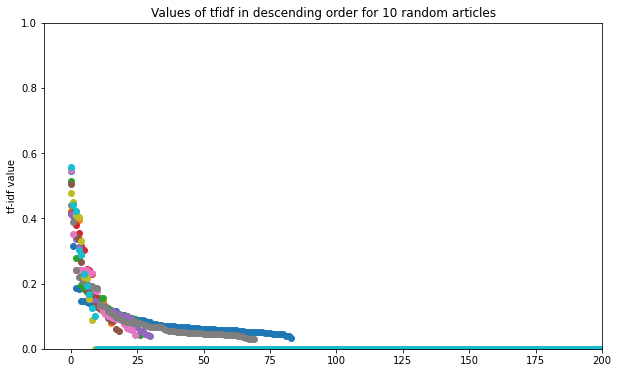

In [412]:
import random
randomlist = random.sample(range(0, tfidf_trans.shape[0]), 10)

plt.figure(figsize=(10,6))

for i in randomlist:
    rowssort = tfidf_matrix.getrow(i).todense().A1.argsort()[::-1]
    valsort = df_tfidf[i].values[rowssort]
    
    plt.plot(valsort, 'o')

ax = plt.gca()
ax.set(xlim=(-10, 200), ylim=(0, 1),
       ylabel='tf-idf value',
       title='Values of tfidf in descending order for 10 random articles');


## Target binarization

In [459]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

## Model

In [460]:
from sklearn.ensemble import RandomForestClassifier
clf_random = RandomForestClassifier()

clf_random.fit(tfidf_trans, train_labels)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [477]:
print(accuracy_score(clf_random.predict(tfidf_trans), train_labels))
print(precision_score(clf_random.predict(tfidf_trans), train_labels, average='micro'))
print(recall_score(clf_random.predict(tfidf_trans), train_labels, average='micro'))
print(f1_score(clf_random.predict(tfidf_trans), train_labels, average='micro'))
# accuracy_score, precision_score, recall_score, f1_score

0.952374823014545
0.9503338898163606
0.9955186359164936
0.9724016441573694


In [484]:
ModelsPerformance = {}
metricsReport('RF', clf_random.predict(tfidf_trans), train_labels) 

------RF Model Metrics-----
Accuracy: 0.9524
Hamming Loss: 0.0007
Precision:
  - Macro: 0.8399
  - Micro: 0.9503
Recall:
  - Macro: 0.9866
  - Micro: 0.9955
F1-measure:
  - Macro: 0.8997
  - Micro: 0.9724


In [489]:
clf_test = RandomForestClassifier()
scoring = ['precision_micro', 'recall_micro', 'f1_micro']
cv=2
scores = cross_validate(clf_test, tfidf_trans, train_labels, cv=cv, scoring=scoring)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [490]:
scores

{'fit_time': array([1.45473504, 1.47627234]),
 'score_time': array([0.94850588, 0.99648857]),
 'test_precision_micro': array([0.94624506, 0.95843046]),
 'test_recall_micro': array([0.48827249, 0.52702414]),
 'test_f1_micro': array([0.64415445, 0.6800827 ])}

#### Explanation of micro and macro average for multiclass:
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [ ]:
print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)))
#Exact Match Ratio: 0.25

print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_true, y_pred))) 
#Hamming loss: 0.4166666666666667

#"samples" applies only to multilabel problems. It does not calculate a per-class measure, instead calculating the metric over the true and predicted classes 
#for each sample in the evaluation data, and returning their (sample_weight-weighted) average.

print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, average='samples'))) 
#Recall: 0.375

print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, average='samples')))
#Precision: 0.5

print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, average='samples'))) 
#F1 Measure: 0.41666666666666663

In [ ]:
from sklearn import metrics
metrics.confusion_matrix(nbc.predict(X_test), y_test)

In [478]:
def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1